# Projeto Final - SQL para Análise de Dados

* O  seguinte notebook faz parte do curso SQL para Análise de Dados, como parte do curso de Cientista de Dados da EBAC.

* Temos como objetivo analisar uma base de dados, armazenado no AWS S3, com informações bancárias, visando gerar insights gerais utilizando queries SQL com Amazon Athena.

* Para fazer o carregamento dos dados a partir das queries e criar as visualiações, utilizamos as seguintes bibliotecas:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1 ) Carregamento dos dados:

Inicialmente foi criado um bucket 'ebacprojfinal' utilizando o sistema de armazenamento S3, no qual os dados foram armazenados. Em seguida, criamos uma tabela contendo os dados utilizando o Amazon Athena:

* Código para criação da tabela:


```sql
CREATE EXTERNAL TABLE IF NOT EXISTS default.credito ( 
  `idade` int,
  `sexo` string,
  `dependentes` int,
  `escolaridade` string,
  `estado_civil` string,
  `salario_anual` string,
  `tipo_cartao` string, 
  `qtd_produtos` bigint,
  `iteracoes_12m` int,
  `meses_inativo_12m` int,
  `limite_credito` float,
  `valor_transacoes_12m` float,
  `qtd_transacoes_12m` int 
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
WITH SERDEPROPERTIES (
  'serialization.format' = ',',
  'field.delim' = ','
) LOCATION <sua-localizacao>
TBLPROPERTIES ('has_encrypted_data'='false');
```

* Informações sobre os tipos de dados podem ser obtidos com:


```sql
DESCRIBE credito;

Resultado da query: 

idade               	int                 	                    
sexo                	string              	                    
dependentes         	int                 	                    
escolaridade        	string              	                    
estado_civil        	string              	                    
salario_anual       	string              	                    
tipo_cartao         	string              	                    
qtd_produtos        	bigint              	                    
iteracoes_12m       	int                 	                    
meses_inativo_12m   	int                 	                    
limite_credito      	float               	                    
valor_transacoes_12m	float               	                    
qtd_transacoes_12m  	int  

* Obtendo o número total de linhas na tabela:

```sql
SELECT COUNT(*) AS total_de_linhas FROM credito;

Resultado da query:

2564

## 2 ) Análise de Dados:

Podemos extrair diversas informações relevantes, gerar insights poderosos, levantar hipóteses e testa-las através de queries da nossa tabela.

Por exemplo, existem 4 classes de cartões e podemos levantar a hipótese de que o valor médio de transações é mais alto para clientes com cartões mais exclusivos. Podemos testar esta hipótese com a seguinte query:

```sql
SELECT tipo_cartao, AVG(valor_transacoes_12m), STDDEV(valor_transacoes_12m) 
FROM credito 
GROUP BY tipo_cartao;

Resultado da query:

In [5]:
q1 = pd.read_csv('queries/query1.csv')
q1.rename(columns= {'_col1': 'média', '_col2': 'desvio'}, inplace=True)
q1

,tipo_cartao,média,desvio
0,blue,1816.7320,680.813134
1,gold,2040.2319,1012.541461
2,silver,1883.2498,828.830616
3,platinum,1543.2250,546.756163


Podemos notar que a média dos valores não tem uma variação significativa em relação ao tipo de cartão, descartando a hipótese anterior.

Analisando ainda o tipo do cartão, podemos ver que ele esta fortemente associado com o número de transações em um ano:

```sql
SELECT tipo_cartao, COUNT(iteracoes_12m) AS interacoes
FROM credito 
GROUP BY tipo_cartao
ORDER BY COUNT(iteracoes_12m) DESC;

Resultado da query:

In [6]:
q2 = pd.read_csv('queries/query2.csv')
q2

,tipo_cartao,interacoes
0,blue,2453
1,silver,93
2,gold,16
3,platinum,2


Podemos ter interesse em detectar qual perfil realiza mais transações em um ano, é possível obter esta informação em relação a diversas variáveis, como por exemplo o nível de escolaridade:

```sql
SELECT escolaridade, COUNT(iteracoes_12m) AS iteracoes
FROM credito GROUP BY escolaridade
ORDER BY COUNT(iteracoes_12m) DESC;

Resultado da query:

In [7]:
q3 = pd.read_csv('queries/query3.csv')
q3

,escolaridade,iteracoes
0,mestrado,810
1,ensino medio,545
2,sem educacao formal,367
3,na,346
4,graduacao,261
5,doutorado,235


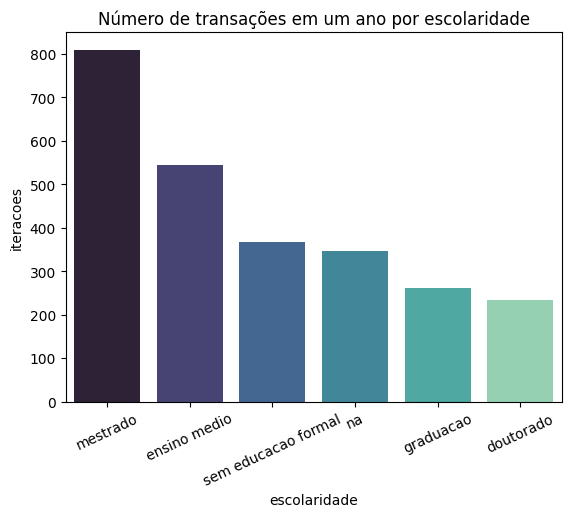

In [14]:
plt.title('Número de transações em um ano por escolaridade')
sns.barplot(data=q3, x='escolaridade', y='iteracoes', palette='mako')
plt.xticks(rotation=25)
plt.show()

Podemos notar que a escolaridade tem forte relação com o número de transações em um ano.

Digamos que a equipe de marketing precisa conhecer melhor os perfis de seus clientes para adequar sua campanha:

```sql
SELECT sexo, COUNT(*) AS contagem, MIN(idade) AS idade_minima, 
AVG(idade) AS media, MAX(idade) AS idade_maxima
FROM credito GROUP BY sexo;

Resultado da query:

In [15]:
q4 = pd.read_csv('queries/query4.csv')
q4

,sexo,contagem,idade_minima,media,idade_maxima
0,F,1001,26,46.429570,67
1,M,1563,26,45.573896,73


Text(0, 0.5, 'Porcentagem')

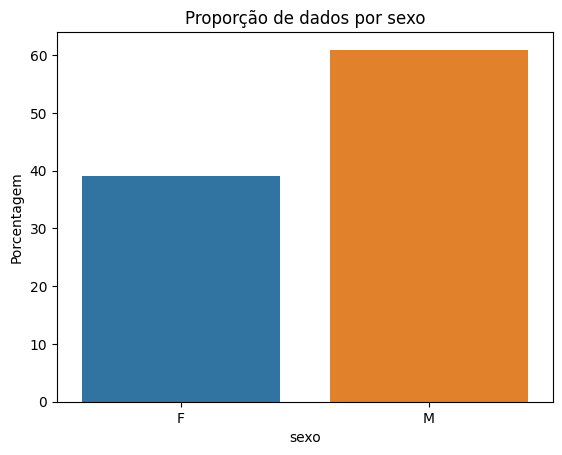

In [20]:
q4['prop'] = (q4['contagem']/q4['contagem'].sum())*100

plt.title('Proporção de dados por sexo')
sns.barplot(data=q4, x='sexo', y='prop')
plt.ylabel('Porcentagem')

Notamos um maior número de entradas de clientes do sexo masculino na nossa tabela, mas como é esta distribuição em função da escolaridade?

```sql
SELECT escolaridade,sexo, COUNT(*) AS contagem
FROM credito GROUP BY escolaridade, sexo;

Resultado da query:

In [21]:
q5 = pd.read_csv('queries/query5.csv')
q5

,escolaridade,sexo,contagem
0,ensino medio,F,197
1,doutorado,M,137
2,doutorado,F,98
3,sem educacao formal,M,210
4,na,M,215
5,sem educacao formal,F,157
6,na,F,131
7,ensino medio,M,348
8,mestrado,F,323
9,mestrado,M,487


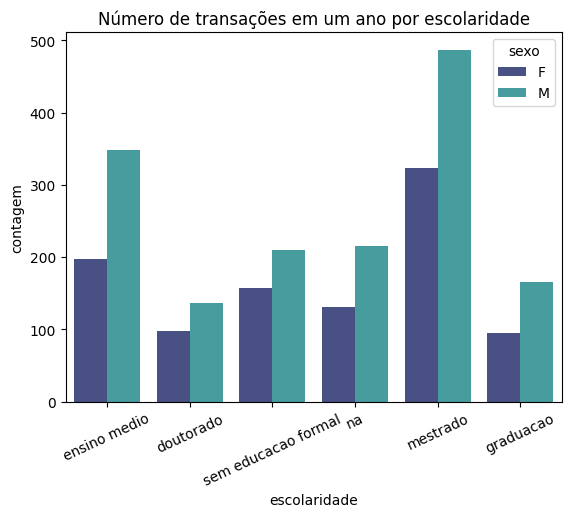

In [23]:
plt.title('Número de transações em um ano por escolaridade')
sns.barplot(data=q5, x='escolaridade', y='contagem', hue='sexo', palette='mako')
plt.xticks(rotation=25)
plt.show()

Podemos concluir que este padrão de entradas se repete independente da escolaridade.

## 3 ) Conclusões:

Podemos gerar mais insights e obter mais informações ampliando nossa análise, neste projeto de conclusão do curso SQL para Análise de Dados utilizamos os serviços S3 e Athena da Amazon e geramos alguns insights sobre os dados abordados que podem ser resumidos em:

* Não existe variação significativa entre a média do valor de transações para diferentes tipos de cartão.

* Os cartões menos exclusivos contém mais transações por ano.

* O maior número de transações por ano esta associado a clientes com a escolaridade de 'Mestrado'.

* Existem mais entradas de clientes do sexo masculino e esta afirmação é verdadeira para cada nível de escolarida.